## RedHat Kaggle

https://www.kaggle.com/c/predicting-red-hat-business-value

##### Load libraries

In [1]:
# pandas
import pandas as pd

# scipy 
import scipy as sp
from scipy.sparse import csr_matrix

# numpy
import numpy as np

# sklearn models 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.cluster import KMeans
from sklearn import tree

# scoring and cross validation 
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, r2_score
from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import validation_curve

# multiprocessing
import multiprocessing
CPUS = multiprocessing.cpu_count()

# collections 
from collections import Counter, defaultdict
from copy import copy

# hashing
import hashlib

# regular expressions 
import re

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pickle
import pickle

# logging 
import logging
logging.basicConfig()

In [2]:
logging.warn('Num CPUs: {}'.format(CPUS))

In [3]:
DIR = './'
FTRAIN = 'Data/act_train.csv.gz'
FTEST = 'Data/act_test.csv.gz'
FPEOPLE = 'Data/people.csv.gz'
FSAMPLE = 'Data/sample_submission.csv.gz'
SPARSE_TRAIN_FILE = DIR+'Data/sparse_train.dat'
SPARSE_TEST_FILE = DIR+'Data/sparse_test.dat'
ID_FILE = DIR+'Data/ids.dat'
Y_FILE = DIR+'Data/y.dat'

##### Custom Functions

In [4]:
class ClusterLogisticRegression(LogisticRegression):
    ''' Create separate LR models for each KMeans cluster '''
    def __init__(self, n_clusters=10, n_jobs=1, C=1.0, models=[], **params):
        self.models = [ LogisticRegression(n_jobs=n_jobs, C=C, **params) 
                           for i in range(n_clusters) ] if not models else models
        self.cluster_model = KMeans(n_clusters=n_clusters, n_jobs=n_jobs)
        self.classes = 2
        self.C = C
        self.n_clusters = n_clusters
        self.n_jobs = n_jobs
    
    def set_params(self, **params):
        for i in range(self.n_clusters):
            self.models[i].set_params(**params)
    
    def fit(self, X, y):
        self.cluster_model.fit(X)
        clusters = self.cluster_model.labels_
        for i in xrange(self.n_clusters):
            self.models[i] = self.models[i].fit(X[clusters==i], 
                                                y[clusters==i])
        return self
    
    def predict_proba(self, X):
        clusters = self.cluster_model.predict(X)
        predictions = np.zeros((X.shape[0], self.classes))
        for i in xrange(self.n_clusters):
            if np.sum(clusters==i)>0:
                predictions[clusters==i,:] = self.models[i].predict_proba(X[clusters==i])[:,:]
        return predictions
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [5]:
def format_col(x, p):
    ''' Add column header to each row value '''
    if type(x)==str:
        return p+'_'+x.replace(' ','_')
    else:
        return p+'_'+str(x)

def update_cols(df,c=1):
    ''' Transform date columns 
        and run format_col on each col
    '''
    # fix date columns
    df['date'] = pd.to_datetime(df['date'])
    
    # split date column into several 
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['qtr'] = df['date'].dt.month // 3
    
    # remove date 
    del df['date']
    
    # get list of columns
    cols = list(df.columns)
    
    # include column name with value
    for p in cols[c:]:
        df.loc[:,p] = df.loc[:,p].apply(lambda x: format_col(x, p) )
    
    return df

In [6]:
def test_scores(y_test, predictions, pr=True):
    ''' Output test scores for predictions '''
    ll = log_loss(y_test, predictions)
    a = accuracy_score(y_test, np.argmax(predictions,axis=1))
    auc = roc_auc_score(np.c_[y_test==0, y_test==1], predictions)
    r = {'logloss':ll,'accuracy':a,'AUC':auc}
    pstr = '''Log-Loss:{logloss:.7f} Accuracy:{accuracy:.7f} AUC:{AUC:.7f}'''
    if pr: print pstr.format(**r)
    return r

# quick RMSE for regression results
RMSE = lambda x,y: np.sqrt(np.mean(x-y)**2)

In [7]:
def create_sparse_ohe_data(df, ohe_dict):
    ''' Create a sparsified OHE matrix '''
    rows = []
    cols = []
    data = []
    for i in xrange(df.shape[0]):
        s = map(lambda x: ohe_dict.get(x,-1), df.iloc[i])
        while True:
            if -1 in s:
                indval = s.index(-1)
                del s[indval]
            else:
                break
        rows += [i]*len(s)
        cols += s
        data += [1]*len(s)
    return csr_matrix((np.array(data),
                (np.array(rows),
                 np.array(cols))),
               shape=(df.shape[0],len(ohe_dict)))

In [8]:
def create_sparse_hash_data(df, num_buckets):
    ''' Group raw features together into 
        hash bucketed features and represent
        as a sparse matrix
    '''
    rows = []
    cols = []
    data = []
    for i in xrange(df.shape[0]):
        mapping = {}
        for f in df.iloc[i]:
            mapping[f] = int(int(hashlib.md5(f).hexdigest(), 16) % num_buckets)
        s = defaultdict(float)
        for bucket in mapping.values():
            s[bucket] += 1.0
        rows += [i]*len(s)
        cols += s.keys()
        data += s.values()
    return csr_matrix((np.array(data),
                (np.array(rows),
                 np.array(cols))),
               shape=(df.shape[0],num_buckets))

In [9]:
def lr_validation_curve(X, y, 
                        param_range= np.logspace(-3, 3, 3), 
                        max_iter=100, 
                        tol=1e-4, 
                        cv=5,
                        n_jobs=CPUS):
    ''' Output the validation curve for LR model '''
    lr_model = LogisticRegression(max_iter=max_iter, tol=tol)
    train_scores, test_scores = validation_curve(lr_model, X, y, 
                                param_name="C", param_range=param_range,
                                cv=cv, scoring="roc_auc", n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with Logistic Regression")
    plt.xlabel("C")
    plt.ylabel("AUC")
    plt.ylim(0.5, 1.1)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

In [10]:
def dump_files(X, X_test, Y, IDS):
    ''' Output data to pickle file '''
    with open(SPARSE_TRAIN_FILE, 'wb') as w:
        pickle.dump(X, w)

    with open(SPARSE_TEST_FILE, 'wb') as w:
        pickle.dump(X_test, w)

    with open(ID_FILE, 'wb') as w:
        pickle.dump(IDS, w)
    
    with open(Y_FILE, 'wb') as w:
        pickle.dump(Y, w)

def read_files():
    ''' Read from pickle dat files '''
    global X
    global X_test
    global IDs
    global Y
    
    with open(SPARSE_TRAIN_FILE, 'rb') as w:
        X = pickle.load(w)

    with open(SPARSE_TEST_FILE, 'rb') as w:
        X_test = pickle.load(w)

    with open(ID_FILE, 'rb') as w:
        IDs = pickle.load(w) 
    
    with open(Y_FILE, 'rb') as w:
        Y = pickle.load(w)

def check_exists(x_str):
    ''' Check if an object exists '''
    x_exists = x_str in locals() or x_str in globals()
    return x_exists

##### Load data

In [11]:
train_raw = pd.read_csv(DIR+FTRAIN)
test_raw = pd.read_csv(DIR+FTEST)
people = pd.read_csv(DIR+FPEOPLE)

In [12]:
train_raw.shape

(2197291, 15)

In [13]:
test_raw.shape

(498687, 14)

In [14]:
people.shape

(189118, 41)

#### Set date types

In [15]:
train_raw['date'] = pd.to_datetime(train_raw['date'])
test_raw['date'] = pd.to_datetime(test_raw['date'])

#### Data exploration

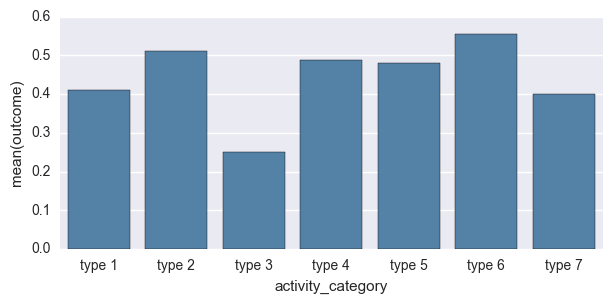

In [16]:
fig, ax = plt.subplots(figsize=(7, 3))
f = train_raw[['activity_category','outcome']].groupby('activity_category').mean()
f = f.reset_index(level=0)
sns.barplot(x='activity_category',y='outcome',data=f,color='steelblue')

In [17]:
f = train_raw[['people_id','outcome']].groupby('people_id').sum()
f['total_activity_cnt'] = train_raw[['people_id','outcome']].groupby('people_id').count()
f['pct'] = f['outcome'] / f['total_activity_cnt']

In [18]:
print 'Median outcome: {}'.format(np.median(f['outcome']))
print 'Median activity count: {}'.format(np.median(f['total_activity_cnt']))
print '% with any positive outcomes: {}%'.format(round(100*np.mean(f['outcome']>0),2))

Median outcome: 0.0
Median activity count: 5.0
% with any positive outcomes: 45.45%


In [19]:
f[(f['pct']!=0) & (f['pct']!=1)].head(10)

,outcome,total_activity_cnt,pct
people_id,,,
ppl_10006,10,11,0.909091
ppl_100075,2,59,0.033898
ppl_100145,36,38,0.947368
ppl_100297,13,16,0.812500
ppl_100324,67,81,0.827160
ppl_100382,12,15,0.800000
ppl_100387,399,450,0.886667
ppl_10041,4,24,0.166667
ppl_100451,5,13,0.384615


In [20]:
p = (train_raw['people_id']=='ppl_100451')
train_raw[p][['people_id','date','outcome']].sort_values(by='date')

,people_id,date,outcome
2861,ppl_100451,2022-08-18,1
2862,ppl_100451,2022-08-27,1
2866,ppl_100451,2022-09-14,1
2872,ppl_100451,2022-09-14,1
2873,ppl_100451,2022-09-15,1
2865,ppl_100451,2022-11-16,0
2864,ppl_100451,2023-01-26,0
2868,ppl_100451,2023-01-27,0
2863,ppl_100451,2023-03-08,0
2869,ppl_100451,2023-03-08,0


#### Create predictive model for people positive outcome

In [21]:
# create outcome variable to predict 
pY = (f['outcome']>0)*1

# merge copy of people data with new outcome variable
p = pd.merge(people.copy(), pd.DataFrame(pY.ravel(),
                              columns=['has_outcome'],
                              index=pY.index),
                              how='left',
                              left_on='people_id',
                              right_index=True).fillna(0)
_Y = p['has_outcome'].ravel()

# save ids 
_IDs = p['people_id']

# clear unused features
del p['people_id']
del p['has_outcome'] 
del p['char_38'] # excluding only integer value
_X = p
del p

# create ohe dict for sparse matrix transform
_X = update_cols(_X)
all_values = set(_X.as_matrix().reshape(1,-1).ravel())
ohe_dict= { k: v for k,v in zip(all_values, xrange(len(all_values))) }
print len(all_values)

# create sparse OHE matrix 
_X = create_sparse_ohe_data(_X, ohe_dict)

# split test and train
_X_train, _X_val, _y_train, _y_val = train_test_split(_X, 
                                                      _Y.T, 
                                                      test_size=0.3)

# fit svm model
svm = LinearSVC(C=1.0)
svm.fit(_X_train, _y_train)

# measure accuracy
print 'SVM accuracy: {}'.format(np.mean(svm.predict(_X_val) == _y_val))

34470
SVM accuracy: 0.846887337845


In [22]:
outcome_feature = pd.DataFrame(svm.predict(_X), index=_IDs, columns=['outcome_feature'])
people = pd.merge(people, outcome_feature,
                  how='left', left_on='people_id', right_index=True)

##### Activity history reference file

In [23]:
train_raw['activity_category'].value_counts()

type 2    904683
type 5    490710
type 3    429408
type 4    207465
type 1    157615
type 6      4253
type 7      3157
Name: activity_category, dtype: int64

def gather_activity_history(values):
    for v in values:
        yield train_raw.groupby(level=0)['activity_category'].apply(lambda x: np.max(x==v))

values = set( train_raw['activity_category'].values )
histories = gather_activity_history( values )
activity_history = pd.concat( histories, axis=1 )
activity_history.columns = values

In [24]:
# gather minimum dates for each person-category
r = train_raw[['people_id',
               'date',
               'activity_category']].groupby(['people_id',
                                              'activity_category']
                                            ).apply(lambda x: np.min(x.date))
r = r.reset_index()
r.columns = ['people_id','activity_category','min_date']

# merge with df data
t = train_raw.loc[:,['people_id','activity_category','date']]
tm = pd.merge(t, r, on=['people_id','activity_category'], how='outer')

# create column for each category type 
def gather_history_cols(values):
    for v in sorted(values):
        check_func = lambda x: np.max((x.activity_category==v)&(x.date>=x.min_date))
        yield tm.groupby(['people_id','date']).apply(check_func)
values = set( train_raw.activity_category.values )
activity_history = pd.concat(gather_history_cols(values), axis=1)*1
activity_history.columns = map(lambda x: 'h'+str(x),range(len(list(values))))
activity_history = activity_history.reset_index()

##### Date probability reference file

In [25]:
date_probs = train_raw.groupby('date')['outcome'].apply(np.mean)
date_probs.columns = ['date_prob']

##### Outcome variable

In [26]:
Y = train_raw['outcome']
del train_raw['outcome']

##### Make numeric features categorical

In [27]:
percentile_ref = people['char_38'].ravel()
compare_percentile = lambda x: round(sp.stats.percentileofscore(percentile_ref, x, kind='weak'),-1)
people['char_38'] = people['char_38'].apply(compare_percentile)

##### Add date probability columns

In [28]:
percentile_ref = date_probs.ravel()
compare_percentile = lambda x: round(sp.stats.percentileofscore(percentile_ref, x, kind='weak'),-1)
date_probs_df = pd.DataFrame()
date_probs_df['date_prob_pctl'] = date_probs.apply(compare_percentile)
date_probs_df = date_probs_df.reset_index()
date_probs_df['date'] = pd.to_datetime(date_probs_df['date'])

In [29]:
def add_date_probs(df, date_probs):
    df = pd.merge(df, date_probs, 
                  how='left', on='date')
    return df

train_raw = add_date_probs(train_raw, date_probs_df)
test_raw = add_date_probs(test_raw, date_probs_df)

##### Add activity history columns

In [30]:
def add_history_cols(df, activity_history):
    df = pd.merge(df, activity_history,
                 how='left', on=['people_id','date'])
    return df

train_raw = add_history_cols(train_raw, activity_history)
test_raw = add_history_cols(test_raw, activity_history)

#### Reindex and clear memory

In [31]:
train_raw.index = train_raw['people_id']
test_raw.index = test_raw['people_id']
people.index = people['people_id']
del train_raw['people_id']
del test_raw['people_id']
del people['people_id']

##### Feature engineering

In [32]:
# updated people cols
people.columns = map(lambda x: 'p_'+x if x!='date' else x, people.columns)
people = update_cols(people, 0)

# train features
train_raw = update_cols(train_raw, 1)

# test features
test_raw = update_cols(test_raw, 1)

##### Transform data to sparse OHE matrix

In [33]:
# merge people and training/test data 
train_full = pd.merge(train_raw, people, left_index=True, right_index=True)
test_full = pd.merge(test_raw, people, left_index=True, right_index=True)

# reset index to include people id
# don't include people id because test set is split by people 
# train_full = train_full.reset_index(level=0)
# test_full = test_full.reset_index(level=0)

# reindex with activity_id and remove as feature
train_full.index = train_full['activity_id']
test_full.index = test_full['activity_id']
del train_full['activity_id']
del test_full['activity_id']

In [34]:
sum(train_full.memory_usage())*1.0/1024**3

1.1459765583276749

In [35]:
sum(test_full.memory_usage())*1.0/1024**3

0.26008553802967072

##### Create OHE dictionary 

In [36]:
all_values = set(train_full.as_matrix().reshape(1,-1).ravel())
ohe_dict= { k: v for k,v in zip(all_values, xrange(len(all_values))) }

In [37]:
len(ohe_dict)

36871

##### Create sparse matrices for test and training datasets

In [38]:
X = create_sparse_ohe_data(train_full, ohe_dict)

In [39]:
X_test = create_sparse_ohe_data(test_full, ohe_dict)

In [40]:
IDs = np.array(test_full.index)

In [41]:
X.shape

(2197291, 36871)

##### Clear unused memory

In [42]:
del train_full 
del train_raw
del test_full
del test_raw
del people 
del ohe_dict
del all_values

#### Write to file

In [43]:
dump_files(X, X_test, Y, IDs)

#### Check data

In [44]:
if not check_exists('X') or check_exists('Y'):
    read_files()

## Baseline model
Use frequency of outcome variable for prediction. 

In [45]:
p = Y.value_counts()*1.0 / X.shape[0]

N = X.shape[0]
predictions = np.zeros((N,2))
for i in xrange(N):
    predictions[i,:] = p

a = accuracy_score(Y, np.argmax(predictions,axis=1))
ll = log_loss(Y, predictions)
auc = roc_auc_score(np.c_[Y==0,Y==1], predictions)
print 'Log-loss: {ll} Accuracy: {acc} AUC:{auc}'.format(acc=a,ll=ll,auc=auc)

Log-loss: 0.686851739242 Accuracy: 0.556045603427 AUC:0.5


## Naive Bayes
Would expect improvement from the baseline model.

In [46]:
from sklearn.naive_bayes import BernoulliNB

# split test and train
N = X.shape[0]
e = N/10*8
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = X[:e,:], X[e:,:], Y[:e], Y[e:]

# train model 
nb = BernoulliNB(alpha=1e-12, binarize=0.0)
nb.fit(X_train, y_train)

# make predictions 
predictions = nb.predict_proba(X_val)
_ = test_scores(y_val, predictions)

Log-Loss:2.2389076 Accuracy:0.8650955 AUC:0.9172802


## SVM 

In [47]:
svc = LinearSVC(C=1.0).fit(X_train, y_train)

In [48]:
a = np.sum(svc.predict(X_val) == y_val)*1.0 / y_val.shape[0]
print 'Raw Accuracy: {}'.format(a)

Raw Accuracy: 0.941600922953


In [49]:
prob_pos = svc.decision_function(X_val)
prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
predictions = np.zeros((X_val.shape[0],2))
predictions[:,1] = prob_pos
predictions[:,0] = 1-prob_pos

In [50]:
_ = test_scores(y_val, predictions)

Log-Loss:0.3917738 Accuracy:0.9004617 AUC:0.9840613


## XGBoost

In [51]:
import xgboost as xgb

In [52]:
def test_scores_xgb(y_val, predictions):
    pfull = np.c_[1-predictions,predictions]
    ll = log_loss(y_val, pfull)
    a = accuracy_score(y_val, np.argmax(pfull ,axis=1))
    auc = roc_auc_score(np.c_[y_val==0, y_val==1], pfull)
    r = {'logloss':ll,'accuracy':a,'AUC':auc}
    return r

In [53]:
dtrain = xgb.DMatrix( X_train, label=y_train.as_matrix() )
dval = xgb.DMatrix( X_val, label=y_val.as_matrix() )
dtest = xgb.DMatrix( X_test )

#### Train model

In [ ]:
d = 10
e = 0.05
param = {'max_depth':d, 
         'eta':e, 
         'subsample':1.0, 
         'colsample_bytree':0.25,
         'silent':1, 
         'lambda':1.0,
         'objective':'binary:logistic',
#          'min_child_weight':0,
#          'booster':'gblinear'
        }
param['eval_metric'] = 'auc'
param['nthread'] = CPUS
evallist  = [(dval,'eval'), (dtrain,'train')]
xgb_model = xgb.train(param.items(), dtrain, 1001, evallist, verbose_eval=100)

In [ ]:
predictions = xgb_model.predict( dval )
test_scores_xgb(y_val, predictions)

## Logistic Regression

#### Check model parameter tuning
Using a sample of data to limit runtime.  
Assumes that sampled validation curve will match full dataset.

In [ ]:
run_charts = True
if run_charts:
    sample = np.random.choice(xrange(X.shape[0]),size=100000)
    lr_validation_curve(X[sample,:], 
                        Y.iloc[sample], 
                        param_range= np.logspace(-3, 5, 6),
                        n_jobs=6)

#### Split train and val 

In [55]:
N = X.shape[0]
e = N/10*8
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = X[:e,:], X[e:,:], Y[:e], Y[e:]

#### Run Model

In [56]:
c = 1e2
lr = LogisticRegression(C=c, max_iter=200, tol=1e-4, n_jobs=CPUS)
lr.fit(X_train, y_train)
predictions = lr.predict_proba(X_val)

In [57]:
_ = test_scores(y_val, predictions)

Log-Loss:0.1819167 Accuracy:0.9399489 AUC:0.9842792


<h3>Logistic Regression Result Tracker</h3>
<table align="left">
<tr>
    <th>Iter</th>
    <th>C</th>
    <th>Clusters</th>
    <th>Tol</th>
    <th>+Features</th>
    <th>AUC</th>
    <th>Log Loss</th>
    <th>Accuracy</th>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-5</td>
    <td></td>
    <td>0.9767696</td>
    <td>0.2064201</td>
    <td>0.9075454</td>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-5</td>
    <td>+Activity history</td>
    <td>0.9767806</td>
    <td>0.2046148</td>
    <td>0.9075249</td>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-5</td>
    <td>+Date Prob</td>
    <td>0.9768128</td>
    <td>0.2063661</td>
    <td>0.9080028</td>
</tr>
<tr>
    <td>300</td>
    <td>100</td>
    <td>1</td>
    <td>1e-5</td>
    <td>+More accurate history</td>
    <td>0.9768163</td>
    <td>0.2062309</td>
    <td>0.9082030</td>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-4</td>
    <td>-Iterations and tol</td>
    <td>0.9770576</td>
    <td>0.2029024</td>
    <td>0.9088720</td>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-3</td>
    <td>-more tol</td>
    <td>0.9766761</td>
    <td>0.1920801</td>
    <td>0.9106515</td>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-4</td>
    <td>+SVM prediction</td>
    <td>0.9842792</td>
    <td>0.1819167</td>
    <td>0.9399489</td>
</tr>

</table>

In [ ]:
# to filter out non-useful coefficients
F = (0.15*lr.coef_.shape[1])
A = np.argsort(np.abs(lr.coef_))[:,::-1].ravel()[:-F]
# X = X[:,A]

#### Submission

In [ ]:
c     = 1e2
tol   = 1e-4
iters = 200
lr = LogisticRegression(C=c, max_iter=iters, tol=tol, n_jobs=CPUS)
lr.fit(X, Y)
predictions = lr.predict_proba(X_test)

In [ ]:
submission = pd.DataFrame(np.vstack((IDs, 
                                     predictions[:,1])).T,
                          columns=['activity_id','outcome'])
submission.to_csv('submission.csv', index=False)

##### Use already-known predictions via forums

In [ ]:
def add_leak_data(submission, loc='./Data/leak.csv.gz'):
    leak = pd.read_csv(loc)
    leak.columns = ['activity_id','leak_outcome']
    leak = leak.loc[(leak['leak_outcome']==1.0) | (leak['leak_outcome']==0.0),:]
    leak_submission = pd.merge(submission, leak, how='left', on='activity_id')
    nonleak = np.isnan(leak_submission['leak_outcome'])
    leak_submission.loc[nonleak,'leak_outcome'] = leak_submission.loc[nonleak, 'outcome']
    del leak_submission['outcome']
    leak_submission.columns = ['activity_id','outcome']
    return leak_submission

leak_submission = add_leak_data(submission)
leak_submission.to_csv('leak_submission.csv', index=False)

## Decision tree Logistic Regression

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',  max_depth=3)
dt.fit(X_train, y_train)

In [ ]:
tree.export_graphviz(dt,
     out_file='tree.dot')

In [ ]:
!dot -Tpng tree.dot -o tree.png 

<h3>Decision tree </h3>
<img src='tree.png' align='left' height='100%' width='500px'/>

In [ ]:
# all thresholds are 0.5
threshold = 0.5

# first level
feature1 = 11566
f1_l = (X_train[:,feature1]<=threshold).A.ravel()
f1_r = (X_train[:,feature1]>threshold).A.ravel()

# second level
feature2 = 19318
f2_l = f1_l & (X_train[:,feature2]<=threshold).A.ravel()
f2_r = f1_r & (X_train[:,feature2]>threshold).A.ravel()

# third level 
feature3 = 6755
f3_l = f2_l & (X_train[:,feature3]<=threshold).A.ravel()
f3_r = f2_l & (X_train[:,feature3]>threshold).A.ravel()

# models
model_f1_r = [ 1.0, 0.0 ] # val outcome is always zero 
model_f2_r = [ 1.0, 0.0 ] # val outcome is nearly always zero 
model_f3_l = LogisticRegression(C=0.1, max_iter=200, tol=1e-4).fit(X_train[f3_l],y_train[f3_l])
model_f3_r = LogisticRegression(C=0.1, max_iter=200, tol=1e-4).fit(X_train[f3_r],y_train[f3_r])

In [ ]:
# first level
f1_l = (X_val[:,feature1]<=threshold).A.ravel()
f1_r = (X_val[:,feature1]>threshold).A.ravel()

# second level
f2_l = f1_l & (X_val[:,feature2]<=threshold).A.ravel()
f2_r = f1_r & (X_val[:,feature2]>threshold).A.ravel()

# third level 
f3_l = f2_l & (X_val[:,feature3]<=threshold).A.ravel()
f3_r = f2_l & (X_val[:,feature3]>threshold).A.ravel()

# predict
predictions = np.zeros((y_val.shape[0], 2))
predictions[f1_r] = model_f1_r
predictions[f2_r] = model_f2_r
predictions[f3_l] = model_f3_l.predict_proba(X_val[f3_l])
predictions[f3_r] = model_f3_r.predict_proba(X_val[f3_r])

In [ ]:
_ = test_scores(y_val, predictions)

<h3>DT Logistic Regression Result Tracker</h3>
<table align="left">
<tr>
    <th>Iter</th>
    <th>C</th>
    <th>Tol</th>
    <th>Depth</th>
    <th>AUC</th>
    <th>Log Loss</th>
    <th>Accuracy</th>
</tr>
<tr>
    <td>200</td>
    <td>1.0</td>
    <td>1e-4</td>
    <td>1</td>
    <td>0.9744524</td>
    <td>0.1952951</td>
    <td>0.9077684</td>
</tr>
<tr>
    <td>200</td>
    <td>10.0</td>
    <td>1e-4</td>
    <td>1</td>
    <td>0.9771368</td>
    <td>0.1897558</td>
    <td>0.9108609</td>
</tr>
<tr>
    <td>200</td>
    <td>10.0</td>
    <td>1e-4</td>
    <td>2</td>
    <td>0.9775437</td>
    <td>0.1890088</td>
    <td>0.9107107</td>
</tr>
<tr>
    <td>200</td>
    <td>100.0</td>
    <td>1e-4</td>
    <td>3</td>
    <td>0.9630686</td>
    <td>0.2355023</td>
    <td>0.8928751</td>
</tr>

</table>